## Load all necessary libraries

In [1]:
import numpy as np
%matplotlib inline
import torch
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd
np.random.seed(1)

## Define network

In [2]:
# Construct class for network
class MLP(nn.Module):

    def __init__(self, input_dim=2, out_dim=1, width=18, depth=6, activation='sin'):
        super(MLP, self).__init__()

        self.depth = depth

        # Activations
        if activation == 'tanh':
          self.activation = nn.Tanh()
        elif activation == 'sin':
          self.activation = torch.sin

        self.out_func = nn.Sigmoid()

        # Need to ensure there is at least one hidden layer
        assert depth > 1

        # First hidden layer
        MLP_list = [nn.Linear(input_dim, width)]

        # Remaining hidden layers
        for _ in range(depth - 2):
            MLP_list.append(nn.Linear(width, width))

        # Output layer
        MLP_list.append(nn.Linear(width, out_dim))

        # Adding list of layers as modules
        self.model = nn.ModuleList(MLP_list)

        # Weights initialization
        def init_weights(layer):
          if isinstance(layer, nn.Linear):
              nn.init.normal_(layer.weight, 0, 1)
              if layer.bias is not None:
                nn.init.normal_(layer.bias, 0, 1)

        self.model.apply(init_weights)

    # Defining forward mode of MLP model
    def forward(self, t, x):
        x = torch.cat((t, x), dim=1)  # Concatenate t and x along the feature dimension
        for i, layer in enumerate(self.model):
            if i < self.depth - 1:
                x = self.activation(layer(x))
            else:
                #x = self.out_func(layer(x))
                x= layer(x)
        return x
        
    # def forward(self, x):
    #     for i, layer in enumerate(self.model):
    #         if i < self.depth-1:
    #             x = self.activation(layer(x))
    #         else:
    #             x = self.out_func(layer(x))
    #     return x

## Define loss function

In [72]:
def loss_fun(t_int,x_int,t_bc,x_bc,t_ic,x_ic, model):
    u = model(t_int,x_int)
    u_t = torch.autograd.grad(
            u, t_int,
            grad_outputs=torch.ones_like(t_int),
            create_graph=True)[0]
    u_x = torch.autograd.grad(
            u, x_int,
            grad_outputs=torch.ones_like(x_int),
            create_graph=True)[0]
    u_xx = torch.autograd.grad(
            u_x, x_int,
            grad_outputs=torch.ones_like(x_int),
            create_graph=True)[0]
    R_int = torch.mean(torch.square(u_t + u * u_x - (0.01/torch.pi) * u_xx))
    
    u_bc = model(t_bc,x_bc)
    R_bc  = torch.mean(torch.square(u_bc))
    
    u_ic = model(t_ic,x_ic)
    R_ic  = torch.mean(torch.square(u_ic + torch.sin(x_train * torch.pi )))

    return R_int,R_bc,R_ic

In [73]:
# Setting devices
if torch.cuda.is_available():
  dev = "cuda:0"
else:
  dev = "cpu"
device = torch.device(dev)
print(device)

cpu


## TRAINING THE MODEL

In [75]:
runs       = 1
max_epochs = 40000

N              = 100
t_train        = torch.linspace(0, 0.5, N, requires_grad=True).reshape(N,1)
x_train        = torch.linspace(-1, 1, N, requires_grad=True).reshape(N,1)
# Generate interior t,x
t_int, x_int = torch.meshgrid(t_train[1:].squeeze(), x_train[1:-1].squeeze())
t_int = t_int.reshape(-1, 1)
x_int = x_int.reshape(-1, 1)
# Generate boundary t,x
t_bc,x_bc = torch.meshgrid(t_train.squeeze(), torch.cat((x_train[:1], x_train[-1:]), dim=0).squeeze())
t_bc = t_bc.reshape(-1, 1)
x_bc = x_bc.reshape(-1, 1)
# Generate initial t,x
t_ic,x_ic = torch.meshgrid(t_train[:1].squeeze(), x_train.squeeze())
t_ic = t_ic.reshape(-1, 1)
x_ic = x_ic.reshape(-1, 1)

loss_int_hist  = [np.zeros(max_epochs) for _ in range(runs)]
loss_bc_hist    = [np.zeros(max_epochs) for _ in range(runs)]
loss_ic_hist    = [np.zeros(max_epochs) for _ in range(runs)]
pred_hist      = [np.zeros(N) for _ in range(runs)]

lambda_b       = 10.0
lambda_ic      =10.0

for run in range(runs):
    print('--- Run ' + str(run + 1))

    model = MLP(activation='tanh')
    # define loss and optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-7)

    for epoch in range(max_epochs):
        # zero the gradient buffers
        optimizer.zero_grad()
        # compute losses
        loss_int,loss_bc,loss_ic = loss_fun(t_int,x_int,t_bc,x_bc,t_ic,x_ic, model)
        loss = loss_int + lambda_b*loss_bc + lambda_ic*loss_ic
        # compute gradients of training loss
        loss.backward()
        # update weights
        optimizer.step()
        # save loss
        loss_int_hist[run][epoch] = loss_int.item()
        loss_bc_hist[run][epoch] = loss_bc.item()
        loss_ic_hist[run][epoch] = loss_ic.item()

        if (epoch+1) % 1000 == 0 or (epoch+1) == max_epochs:
            print(f'   --- epoch {epoch+1}: loss_int = {loss_int.item():.4e}, loss_bc = {loss_bc.item():.4e}, loss_ic = {loss_ic.item():.4e}')

--- Run 1
   --- epoch 1000: loss_int = 2.9882e+01, loss_bc = 3.2771e-01, loss_ic = 1.4049e+00
   --- epoch 2000: loss_int = 7.1600e+00, loss_bc = 1.8968e-02, loss_ic = 4.9333e-01
   --- epoch 3000: loss_int = 3.4004e+00, loss_bc = 8.5069e-03, loss_ic = 1.8025e-01
   --- epoch 4000: loss_int = 1.6322e+00, loss_bc = 4.5907e-03, loss_ic = 8.3658e-02
   --- epoch 5000: loss_int = 1.0642e+00, loss_bc = 3.6049e-03, loss_ic = 5.8408e-02
   --- epoch 6000: loss_int = 7.1871e-01, loss_bc = 2.6403e-03, loss_ic = 4.0299e-02
   --- epoch 7000: loss_int = 5.0112e-01, loss_bc = 2.1177e-03, loss_ic = 2.2682e-02
   --- epoch 8000: loss_int = 3.5387e-01, loss_bc = 1.3567e-03, loss_ic = 1.2665e-02
   --- epoch 9000: loss_int = 2.4667e-01, loss_bc = 7.7830e-04, loss_ic = 8.6993e-03
   --- epoch 10000: loss_int = 1.7066e-01, loss_bc = 4.0673e-04, loss_ic = 6.1038e-03
   --- epoch 11000: loss_int = 1.2586e-01, loss_bc = 1.6726e-04, loss_ic = 4.7471e-03
   --- epoch 12000: loss_int = 1.0021e-01, loss_bc = 

NameError: name 'i' is not defined

## DO THE PLOTS

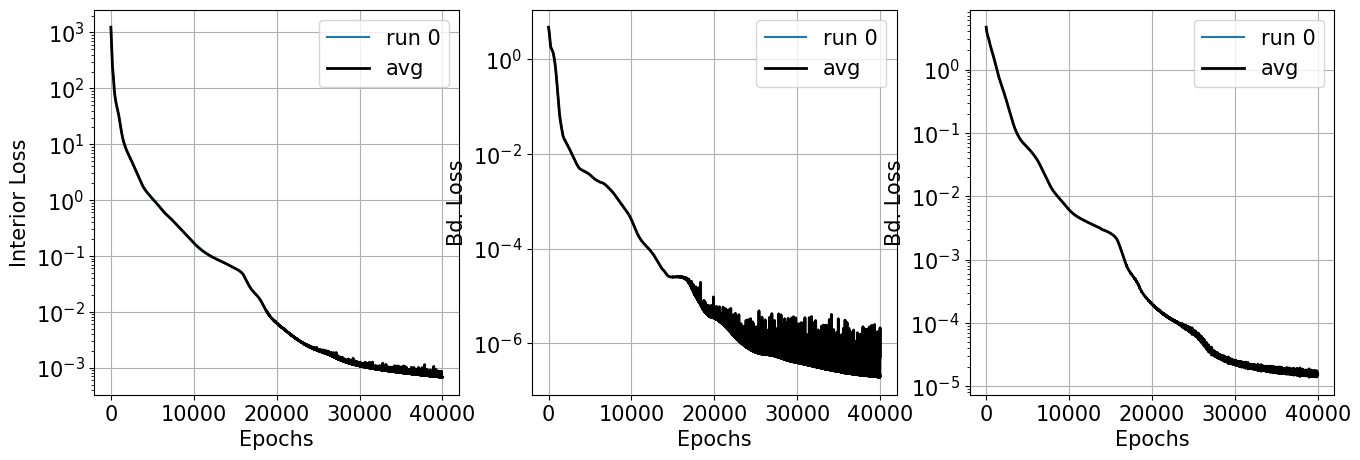

In [79]:
lt_list = ['o','x','s','v']
plt.rcParams.update({'font.size': 15})
fig, ax  = plt.subplots(1,3,figsize=(8*2, 5))

avg_loss_int = np.zeros(max_epochs)
avg_loss_bc   = np.zeros(max_epochs)
avg_loss_ic   = np.zeros(max_epochs)
for run in range(runs):
    ax[0].semilogy(loss_int_hist[run],label='run '+str(run))
    avg_loss_int += np.array(loss_int_hist[run])
    ax[1].semilogy(loss_bc_hist[run],label='run '+str(run))
    avg_loss_bc += np.array(loss_bc_hist[run])
    ax[2].semilogy(loss_ic_hist[run],label='run '+str(run))
    avg_loss_ic += np.array(loss_ic_hist[run])

    ax[0].semilogy(avg_loss_int/runs,label='avg',color='k',lw=2)
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Interior Loss')
    ax[0].grid()
    ax[0].legend()
    #ax[0].set_title(f'Pe = {Pe}, Da = {Da}')

    ax[1].semilogy(avg_loss_bc/runs,label='avg',color='k',lw=2)
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Bd. Loss')
    ax[1].grid()
    ax[1].legend()
    #ax[1].set_title(f'Pe = {Pe}, Da = {Da}')

    ax[2].semilogy(avg_loss_ic/runs,label='avg',color='k',lw=2)
    ax[2].set_xlabel('Epochs')
    ax[2].set_ylabel('Bd. Loss')
    ax[2].grid()
    ax[2].legend()


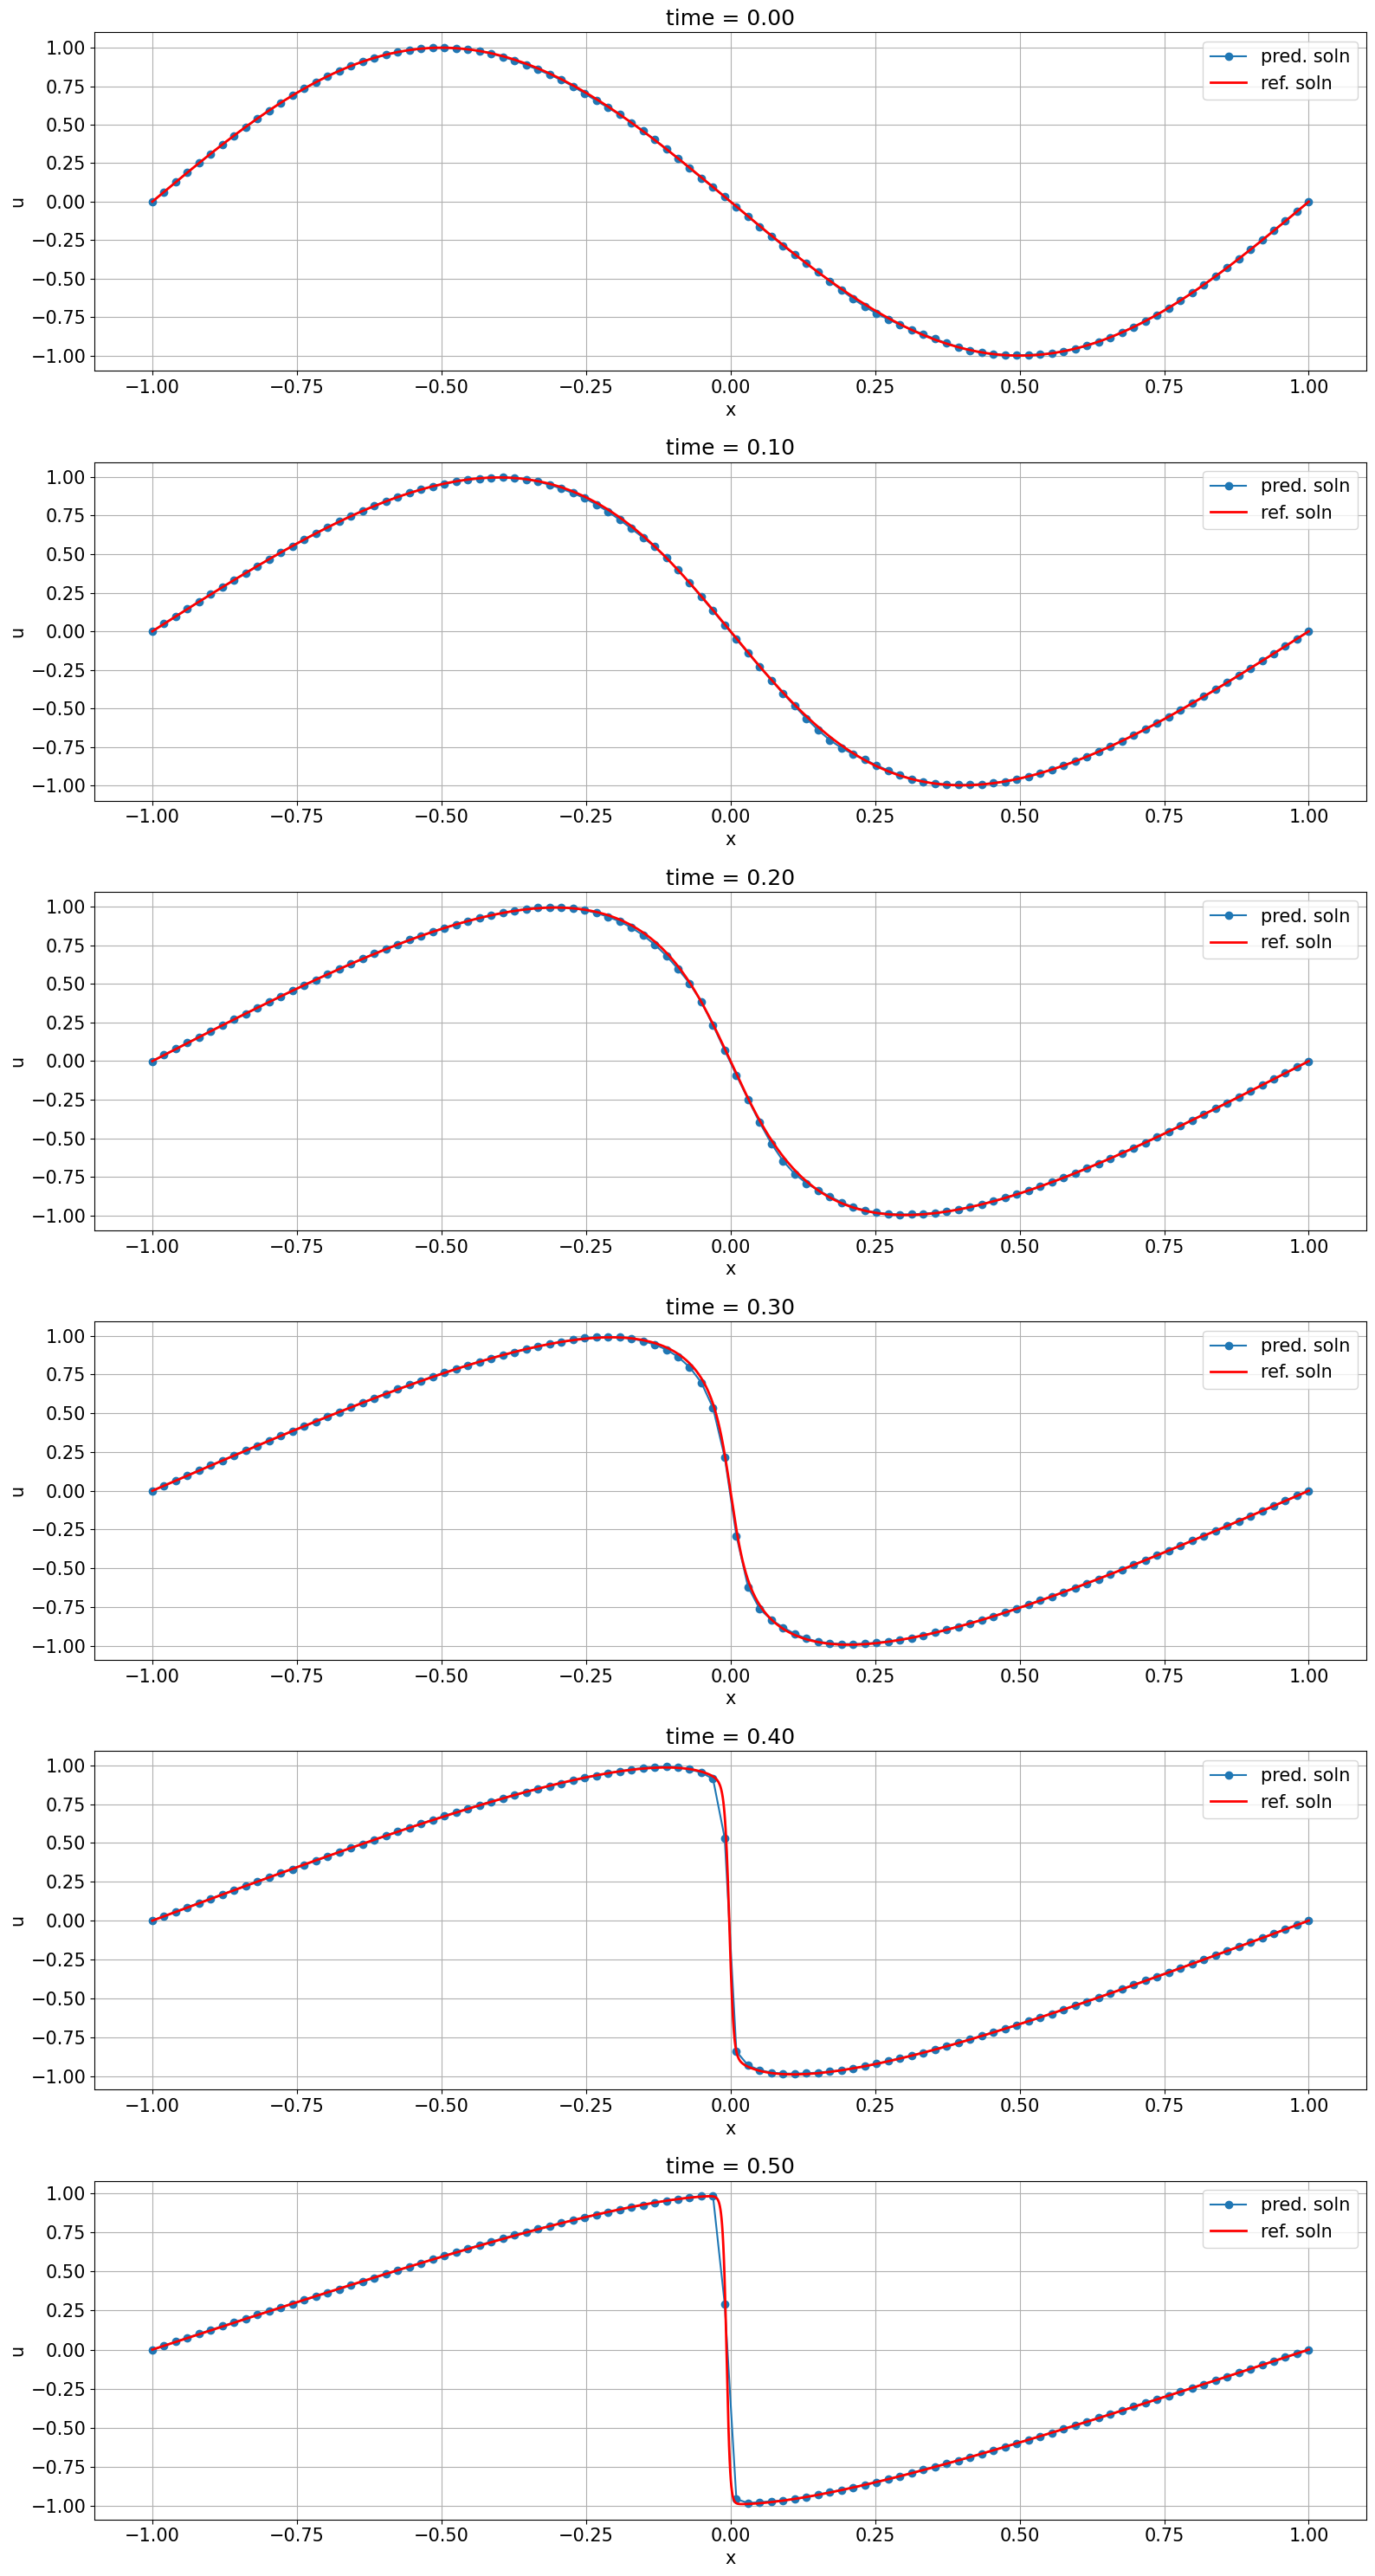

In [128]:
df = pd.read_excel('Bergurs_Sol.xlsx', sheet_name='Sheet1', header=None)
Num_sol = torch.tensor(df.values, dtype=torch.float32)
t_sample = torch.tensor([0,.1,.2,.3,.4,.5])
plt.rcParams.update({'font.size': 15})
fig, ax  = plt.subplots(len(t_sample),1,figsize=(16,5*len(t_sample)))

for l,time in enumerate(t_sample):
    t_test, x_test = torch.meshgrid(time, x_train.squeeze())
    t_test = t_test.reshape(-1, 1)
    x_test = x_test.reshape(-1, 1)

    with torch.no_grad():
        pred_hist = model(t_test,x_test).detach().numpy()

    ax[l].plot(x_test.detach().numpy(),pred_hist,marker='o',label='pred. soln')
    ax[l].plot(Num_sol[0,:],Num_sol[l+1,:],'r-',lw=2,label='ref. soln')
    ax[l].set_xlabel('x')
    ax[l].set_ylabel('u')
    ax[l].grid()
    ax[l].legend()
    ax[l].set_title(f'time = {time:.2f}')

fig.tight_layout()
plt.savefig('Bergurs Equation.jpeg', format='jpeg')